# Phase 1 - Binary classifier to predict in-hospital mortality

We propose to a two-phase model framework to predict in-hospital mortality and death time in hours. This notebook presents the machine learning pipeline for model training, hyperparameter tuning and model evaluation in Phase 1. In Phase 1, a binary classifier was trained to predict in-hospital mortality using the 123 features extracted from the previous stage of feature engineering in Hive. 

* Part 1. Define classes and methods for the machine learning pipieline
* Part 2. Model training and evaluation using 6-hour, 12-hour, 24-hour data
* Part 3. Visualization of ROC curves
* Part 4: Visualization of feature importance

In [15]:
%pip install pandas numpy scikit-learn matplotlib

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import *
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib
import matplotlib.pyplot as plt
from utils import connect_db
from pathlib import Path
import joblib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


---
## Part 1. Define classes and methods for the machine learning pipieline

First, we define the classes of `CustomLabelBinarizer`, `ItemSelector` and `MultiItemSelector` for custom data transformation in sklearn pipieline. Specifically, 
* `CustomLabelBinarizer` converts multi-class labels to binary labels.
* `ItemSelector` and `MultiItemSelector` select custom features from the input dataframe.

In [16]:
unseen_label = "__New__"
seed = 200

class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.le = LabelEncoder()
        self.lb = LabelBinarizer()
        self.seen_labels = set()
        
    def fit(self, x, y=None,**fit_params):
        self.seen_labels = set(x)
        self.seen_labels.add(unseen_label)
        
        # add "unseen" to X
        x_new = list(x)
        x_new.append(unseen_label)

        label_encoded = self.le.fit_transform(x_new)
        self.lb.fit(label_encoded)
        return self
    
    def transform(self, x):
        x_new = list(map(lambda label: label if label in self.seen_labels else unseen_label, list(x)))
        label_encoded = self.le.transform(x_new)
        return self.lb.transform(label_encoded)
    
    
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[self.key]

    
class MultiItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key_list):
        self.key_list = key_list

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[self.key_list]

Next, we define a useful methods `evaluate()` for model evaluation. It would evaluates the model performance and prints a detailed report of the performance metrics e.g. accuracy, AUC score, precision, recall and F1 score.

In [17]:
def evaluate(y_true, y_pred, y_pred_proba):
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1score = f1_score(y_true, y_pred)   
    print ("Accuracy : {:.4f}".format(acc))
    print("AUC score : {:.4f}".format(auc))
    print("Precision : {:.4f}".format(precision))
    print("Recall : {:.4f}".format(recall))
    print("F1 score : {:.4f}".format(f1score))
    print("\nClassification report : \n", classification_report(y_true, y_pred))
    print("\nConfusion matrix : \n", confusion_matrix(y_true, y_pred))
    return acc, auc, precision, recall, f1score

Now, we are ready to define the main method `train_evaluate_model`. The method does the following:

* Split data into 80% training set and 20% test set
* Build custom machine learning pipeline which 
    * select specified features from the input dataframe (`ItemSelector` and `MultiItemSelector`) 
    * transform categorical data into binary label (`CustomLabelBinarizer`) 
    * impute missing values for numerical data with median (`Imputer`)
    * train `RandomForestClassifier` using `GridSearchCV` on 5-fold CV of the training set
    * find the best parameter set from the grid search
* Evaluate the model performance using the best parameter set on the test set

Note that `hospital_expire_flag=1` indicates in-hospital mortality. We will train the classifier to predict this mortality label. Also note that we have selected 123 extracted features covering 3 categorial variables and 120 numerical variables. 

In [18]:
def train_evaluate_model(df):
    
    # split data into 80% training set, 20% test set
    train_cv_df = df.sample(frac=0.8, random_state=seed)
    test_df = df.drop(train_cv_df.index)
    print(df.shape, train_cv_df.shape, test_df.shape)

    # define the machine learning pipeline
    discrete_pipeline = Pipeline([
        ("feature_union", FeatureUnion(
            transformer_list=[
                # categorical pipeline
                ('ethnicity', Pipeline([
                    ("selector", ItemSelector(key='ethnicity')),
                    ("binarizer", CustomLabelBinarizer())
                ])),            
                ("gender", Pipeline([
                    ("selector", ItemSelector(key='gender')),
                    ("binarizer", CustomLabelBinarizer())
                ])),
                ("admission_type", Pipeline([
                    ("selector", ItemSelector(key='admission_type')),
                    ("binarizer", CustomLabelBinarizer())
                ])),

                # numerical pipeline
                ("numerical", Pipeline([
                    ("selector", MultiItemSelector(key_list=
                          ['age', 'icustay_num',
                           'heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
                           'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean', 
                           'heartrate_min', 'sysbp_min', 'diasbp_min','meanbp_min', 
                           'resprate_min', 'tempc_min', 'spo2_min', 'glucose_min',
                           'heartrate_max', 'sysbp_max', 'diasbp_max', 'meanbp_max',
                           'resprate_max', 'tempc_max', 'spo2_max', 'glucose_max', 
                           'gcs_mean', 'gcsmotor_mean', 'gcsverbal_mean', 'gcseyes_mean', 'endotrachflag_mean',
                           'gcs_min', 'gcsmotor_min', 'gcsverbal_min', 'gcseyes_min', 'endotrachflag_min', 
                           'gcs_max', 'gcsmotor_max', 'gcsverbal_max', 'gcseyes_max', 'endotrachflag_max', 
                           'baseexcess_mean', 'carboxyhemoglobin_mean', 'methemoglobin_mean', 
                           'po2_mean', 'pco2_mean', 'ph_mean', 'pao2fio2ratio_mean', 'totalco2_mean', 
                           'aniongap_mean', 'albumin_mean', 'bands_mean', 'bicarbonate_mean', 
                           'bilirubin_mean', 'calcium_mean', 'creatinine_mean', 'chloride_mean', 
                           'hematocrit_mean', 'hemoglobin_mean', 'lactate_mean', 'platelet_mean', 
                           'potassium_mean', 'ptt_mean', 'inr_mean', 'sodium_mean', 'bun_mean', 'wbc_mean',
                           'baseexcess_min', 'carboxyhemoglobin_min', 'methemoglobin_min',
                           'po2_min', 'pco2_min', 'ph_min', 'pao2fio2ratio_min', 'totalco2_min',
                           'aniongap_min', 'albumin_min', 'bands_min', 'bicarbonate_min',
                           'bilirubin_min', 'calcium_min', 'creatinine_min', 'chloride_min',
                           'hematocrit_min', 'hemoglobin_min', 'lactate_min', 'platelet_min',
                           'potassium_min', 'ptt_min', 'inr_min', 'sodium_min', 'bun_min', 'wbc_min', 
                           'baseexcess_max', 'carboxyhemoglobin_max', 'methemoglobin_max', 
                           'po2_max', 'pco2_max', 'ph_max', 'pao2fio2ratio_max', 'totalco2_max',          
                           'aniongap_max', 'albumin_max', 'bands_max', 'bicarbonate_max', 
                           'bilirubin_max', 'calcium_max', 'creatinine_max', 'chloride_max', 
                           'hematocrit_max', 'hemoglobin_max', 'lactate_max', 'platelet_max', 
                           'potassium_max', 'ptt_max', 'inr_max', 'sodium_max', 'bun_max', 'wbc_max', 
                           'urineoutput'])),
                    # impute missing values with median
                    ("imputer", SimpleImputer(strategy="median")),
                ]))
            ]
        )),

        ("algorithm", RandomForestClassifier(n_jobs=-1))
    ])
    
    # define the parameter grid
    parameters = {'algorithm__n_estimators': [100, 250, 500],
                  'algorithm__max_features': ["auto", "sqrt", "log2"],
                  "algorithm__criterion": ["gini", "entropy"],
                  "algorithm__max_depth": [5, 10, 30],
                  "algorithm__bootstrap": [True, False]}
    
    # grid search on 5-fold CV, trained on 80% training set
    grid_search = GridSearchCV(discrete_pipeline, parameters, n_jobs=-1, verbose=0, refit=True, cv=5, scoring='roc_auc')
    grid_search.fit(train_cv_df, train_cv_df.hospital_expire_flag)

    # retrieve the best parameter set from grid search
    print("\nGrid Search Best parameters set :")
    print(grid_search.best_params_)
    print("\nBest score: %0.3f" % grid_search.best_score_)
    
    # print test score on each fit
#     print("\nGrid scores :")
#     means = grid_search.cv_results_['mean_test_score']
#     stds = grid_search.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

    # evaluate model performance on test set
    print("\nEvaluation on Test Set (20%) :")
    test_actual = test_df.hospital_expire_flag
    test_pred = grid_search.predict(test_df)
    test_pred_proba = grid_search.predict_proba(test_df)[:,1]
    evaluate(test_actual, test_pred, test_pred_proba)

    return grid_search, test_actual, test_pred_proba

---
## Part 2. Model training and evaluation using 6-hour, 12-hour, 24-hour data
Now we have defined our custom machine learning pipeline, we are ready to fit the 6-hour, 12-hour and 24-hour data to the pipeline respectively.

In [19]:
# load 6-hour, 12-hour and 24-hour data extracted previously using Hive

#cohort = connect_db(query)
#df_6hr = pd.read_csv('../data/mp_data_6hr.csv')
#df_12hr = pd.read_csv('../data/mp_data_12hr.csv')
#df_24hr = pd.read_csv('../data/mp_data_24hr.csv')
query = """select * from mp_data_6hr"""
df_6hr = connect_db(query)
query = """select * from mp_data_12hr"""
df_12hr = connect_db(query)
query = """select * from mp_data_24hr"""
df_24hr = connect_db(query)

print(df_6hr.shape, df_12hr.shape, df_24hr.shape)
df_6hr.head()

/Users/debduttaguharoy/Developer/Y2 - Master's Thesis/Usecases/Predicting-Death-Time-and-Mortality/Model/Code/Notebooks/utils.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(query, con=con)


(49632, 131) (49632, 131) (49632, 131)


,subject_id,hadm_id,icustay_id,dbsource,expire_flag,hospital_expire_flag,deathtime_hours,hosp_deathtime_hours,age,gender,...,hemoglobin_max,lactate_max,platelet_max,potassium_max,ptt_max,inr_max,sodium_max,bun_max,wbc_max,urineoutput
0,3,145834,211552,carevue,1,0,5669.0,NaN,76.5246,M,...,10.1,8.0,221.5,4.05,52.35,1.7,141.5,42.0,15.2,20.0
1,4,185777,294638,carevue,0,0,NaN,NaN,47.8450,F,...,10.6,NaN,201.0,3.30,33.20,1.1,141.0,10.0,9.7,550.0
2,6,107064,228232,carevue,0,0,NaN,NaN,65.9398,F,...,9.2,NaN,330.0,4.80,41.20,1.1,134.0,65.0,10.6,760.0
3,9,150750,220597,carevue,1,1,107.0,118.0,41.7887,M,...,14.0,1.9,NaN,2.90,NaN,NaN,138.0,NaN,NaN,1450.0
4,11,194540,229441,carevue,1,0,5082.0,NaN,50.1476,F,...,12.6,NaN,258.0,3.90,NaN,NaN,141.0,14.0,9.3,400.0


In [20]:
grid_search = {}
test_actual = {}
test_pred_proba = {}

# fit the pipeline and evaluate the model using 6-hour data
model, test_actual[0], test_pred_proba[0] = train_evaluate_model(df_6hr)
joblib.dump(model, "phase1_gridsearch_6h.pkl")


(49632, 131) (39706, 131) (9926, 131)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warnin


Grid Search Best parameters set :
{'algorithm__bootstrap': False, 'algorithm__criterion': 'entropy', 'algorithm__max_depth': 30, 'algorithm__max_features': 'log2', 'algorithm__n_estimators': 500}

Best score: 0.884

Evaluation on Test Set (20%) :


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warnin

Accuracy : 0.9055
AUC score : 0.8836
Precision : 0.8404
Recall : 0.2249
F1 score : 0.3549

Classification report : 
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      8779
           1       0.84      0.22      0.35      1147

    accuracy                           0.91      9926
   macro avg       0.87      0.61      0.65      9926
weighted avg       0.90      0.91      0.88      9926


Confusion matrix : 
 [[8730   49]
 [ 889  258]]


['phase1_gridsearch_6h.pkl']

In [21]:
# fit the pipeline and evaluate the model using 12-hour data
model, test_actual[1], test_pred_proba[1] = train_evaluate_model(df_12hr)
joblib.dump(model, "phase1_gridsearch_12h.pkl")


(49632, 131) (39706, 131) (9926, 131)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warnin


Grid Search Best parameters set :
{'algorithm__bootstrap': False, 'algorithm__criterion': 'entropy', 'algorithm__max_depth': 30, 'algorithm__max_features': 'log2', 'algorithm__n_estimators': 500}

Best score: 0.903

Evaluation on Test Set (20%) :


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warnin

Accuracy : 0.9137
AUC score : 0.9046
Precision : 0.8816
Recall : 0.2921
F1 score : 0.4388

Classification report : 
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      8779
           1       0.88      0.29      0.44      1147

    accuracy                           0.91      9926
   macro avg       0.90      0.64      0.70      9926
weighted avg       0.91      0.91      0.89      9926


Confusion matrix : 
 [[8734   45]
 [ 812  335]]


['phase1_gridsearch_12h.pkl']

In [22]:
# fit the pipeline and evaluate the model using 24-hour data
model, test_actual[2], test_pred_proba[2] = train_evaluate_model(df_24hr)
joblib.dump(model, "phase1_gridsearch_24h.pkl")

(49632, 131) (39706, 131) (9926, 131)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warnin


Grid Search Best parameters set :
{'algorithm__bootstrap': False, 'algorithm__criterion': 'entropy', 'algorithm__max_depth': 30, 'algorithm__max_features': 'sqrt', 'algorithm__n_estimators': 250}

Best score: 0.919

Evaluation on Test Set (20%) :


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warnin

Accuracy : 0.9196
AUC score : 0.9185
Precision : 0.8375
Recall : 0.3775
F1 score : 0.5204

Classification report : 
               precision    recall  f1-score   support

           0       0.92      0.99      0.96      8779
           1       0.84      0.38      0.52      1147

    accuracy                           0.92      9926
   macro avg       0.88      0.68      0.74      9926
weighted avg       0.91      0.92      0.91      9926


Confusion matrix : 
 [[8695   84]
 [ 714  433]]


['phase1_gridsearch_24h.pkl']

---
## Part 3. Visualization of ROC curves

Just now, we have trained random forest classifiers using 6-hour, 12-hour and 24-hour data respectively. We can now compare and visualize their ROC curves on the test set.

In [23]:
fpr = {}  #false positive rate
tpr = {}  #true positive rate
roc_auc = {}  #auc score

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(test_actual[i], test_pred_proba[i])
    roc_auc[i] = roc_auc_score(test_actual[i], test_pred_proba[i])

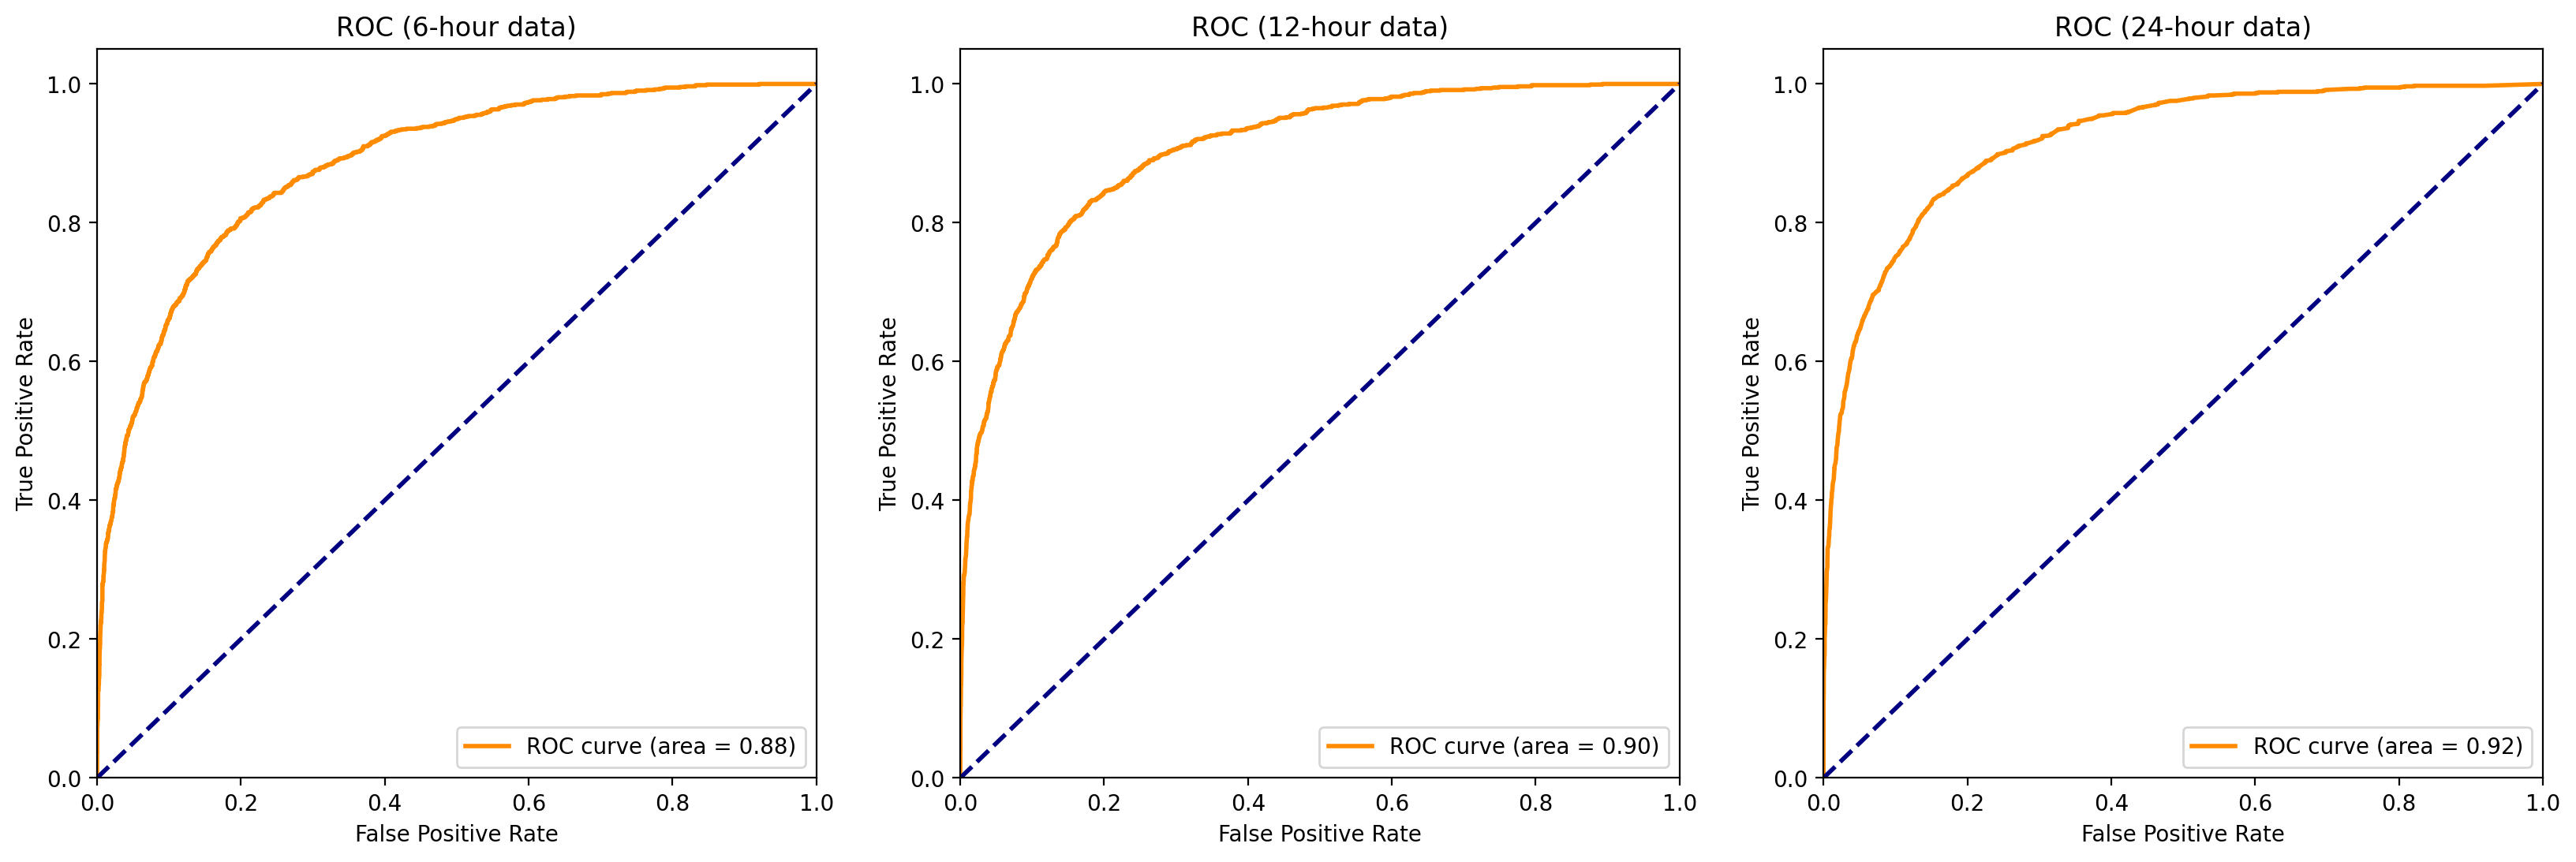

In [24]:
fig = plt.figure()
fig.set_size_inches(20,6)

plt.subplot(1,3,1)
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (6-hour data)')
plt.legend(loc="lower right")

plt.subplot(1,3,2)
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (12-hour data)')
plt.legend(loc="lower right")

plt.subplot(1,3,3)
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (24-hour data)')
plt.legend(loc="lower right")

# Get the current working directory
current_directory = Path.cwd()

# Build the path to the Images folder
img_dir = current_directory / 'data' / 'Model' / 'Code' / 'Images'
img_dir.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist

# Save the figure
fig.savefig(img_dir / 'figure2.png', bbox_inches='tight', pad_inches=0.5)

#fig.savefig('../img/figure2.png')
plt.show()

---
## Part 4. Visualization of Feature Importance

* In this part, we want to dive deeper to visualize the feature importance of the random forest classifier trained on 6-hour ICU data. Let's us first retrain the classifier with the best parameter set resulted from the grid search in Part 2, so that we can retreive the feature importance.

In [25]:
# show best parameter resulted from grid search
grid_search[0].best_params_

KeyError: 0

In [ ]:
# load data
query = """select * from mp_data_6hr"""
df_6hr = connect_db(query)

# define features
categorical_features = ['gender', 'ethnicity', 'admission_type']
numerical_features = ['age', 'icustay_num',
                       'heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
                       'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean', 
                       'heartrate_min', 'sysbp_min', 'diasbp_min','meanbp_min', 
                       'resprate_min', 'tempc_min', 'spo2_min', 'glucose_min',
                       'heartrate_max', 'sysbp_max', 'diasbp_max', 'meanbp_max',
                       'resprate_max', 'tempc_max', 'spo2_max', 'glucose_max', 
                       'gcs_mean', 'gcsmotor_mean', 'gcsverbal_mean', 'gcseyes_mean', 'endotrachflag_mean',
                       'gcs_min', 'gcsmotor_min', 'gcsverbal_min', 'gcseyes_min', 'endotrachflag_min', 
                       'gcs_max', 'gcsmotor_max', 'gcsverbal_max', 'gcseyes_max', 'endotrachflag_max', 
                       'baseexcess_mean', 'carboxyhemoglobin_mean', 'methemoglobin_mean', 
                       'po2_mean', 'pco2_mean', 'ph_mean', 'pao2fio2ratio_mean', 'totalco2_mean', 
                       'aniongap_mean', 'albumin_mean', 'bands_mean', 'bicarbonate_mean', 
                       'bilirubin_mean', 'calcium_mean', 'creatinine_mean', 'chloride_mean', 
                       'hematocrit_mean', 'hemoglobin_mean', 'lactate_mean', 'platelet_mean', 
                       'potassium_mean', 'ptt_mean', 'inr_mean', 'sodium_mean', 'bun_mean', 'wbc_mean',
                       'baseexcess_min', 'carboxyhemoglobin_min', 'methemoglobin_min',
                       'po2_min', 'pco2_min', 'ph_min', 'pao2fio2ratio_min', 'totalco2_min',
                       'aniongap_min', 'albumin_min', 'bands_min', 'bicarbonate_min',
                       'bilirubin_min', 'calcium_min', 'creatinine_min', 'chloride_min',
                       'hematocrit_min', 'hemoglobin_min', 'lactate_min', 'platelet_min',
                       'potassium_min', 'ptt_min', 'inr_min', 'sodium_min', 'bun_min', 'wbc_min', 
                       'baseexcess_max', 'carboxyhemoglobin_max', 'methemoglobin_max', 
                       'po2_max', 'pco2_max', 'ph_max', 'pao2fio2ratio_max', 'totalco2_max',          
                       'aniongap_max', 'albumin_max', 'bands_max', 'bicarbonate_max', 
                       'bilirubin_max', 'calcium_max', 'creatinine_max', 'chloride_max', 
                       'hematocrit_max', 'hemoglobin_max', 'lactate_max', 'platelet_max', 
                       'potassium_max', 'ptt_max', 'inr_max', 'sodium_max', 'bun_max', 'wbc_max', 
                       'urineoutput']
features = categorical_features + numerical_features 

# impute missing values of numerical features with median
for col in numerical_features:
    df_6hr[col].fillna(df_6hr[col].median(), inplace=True)
    
# encoding categorical features
le_gender = LabelEncoder()
df_6hr['gender'] = le_gender.fit_transform(df_6hr.gender)
le_enthnicity = LabelEncoder()
df_6hr['ethnicity'] = le_enthnicity.fit_transform(df_6hr.ethnicity)
le_admission_type = LabelEncoder()
df_6hr['admission_type'] = le_admission_type.fit_transform(df_6hr.admission_type)

# train-test split
y = df_6hr.hospital_expire_flag
X = df_6hr[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# train classifier with the best paramter set
best_params = grid_search[0].best_params_
clf = RandomForestClassifier(n_estimators=best_params['algorithm__n_estimators'], 
                            max_features=best_params['algorithm__max_features'],
                            max_depth=best_params['algorithm__max_depth'],
                            bootstrap=best_params['algorithm__bootstrap'],
                            criterion=best_params['algorithm__criterion'],
                            random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)
print("Accuracy score on training set and test set: ", clf.score(X_train, y_train), clf.score(X_test, y_test))

/Users/debduttaguharoy/Developer/Y2 - Master's Thesis/Usecases/Predicting-Death-Time-and-Mortality/Model/Code/Notebooks/utils.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(query, con=con)
/var/folders/qd/hxnw7jb56lb72yft16bm17c40000gn/T/ipykernel_26665/3044520596.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_6hr[col].fillna(df_6hr[col]

Accuracy score on training set and test set:  0.9995214708475003 0.9083308149491286


Top 10 features
age              0.024163
resprate_mean    0.021908
urineoutput      0.020705
gcsmotor_max     0.016740
sysbp_mean       0.016626
resprate_min     0.016458
gcseyes_mean     0.016343
tempc_mean       0.015781
resprate_max     0.015243
sysbp_min        0.015226
dtype: float64


<Axes: >

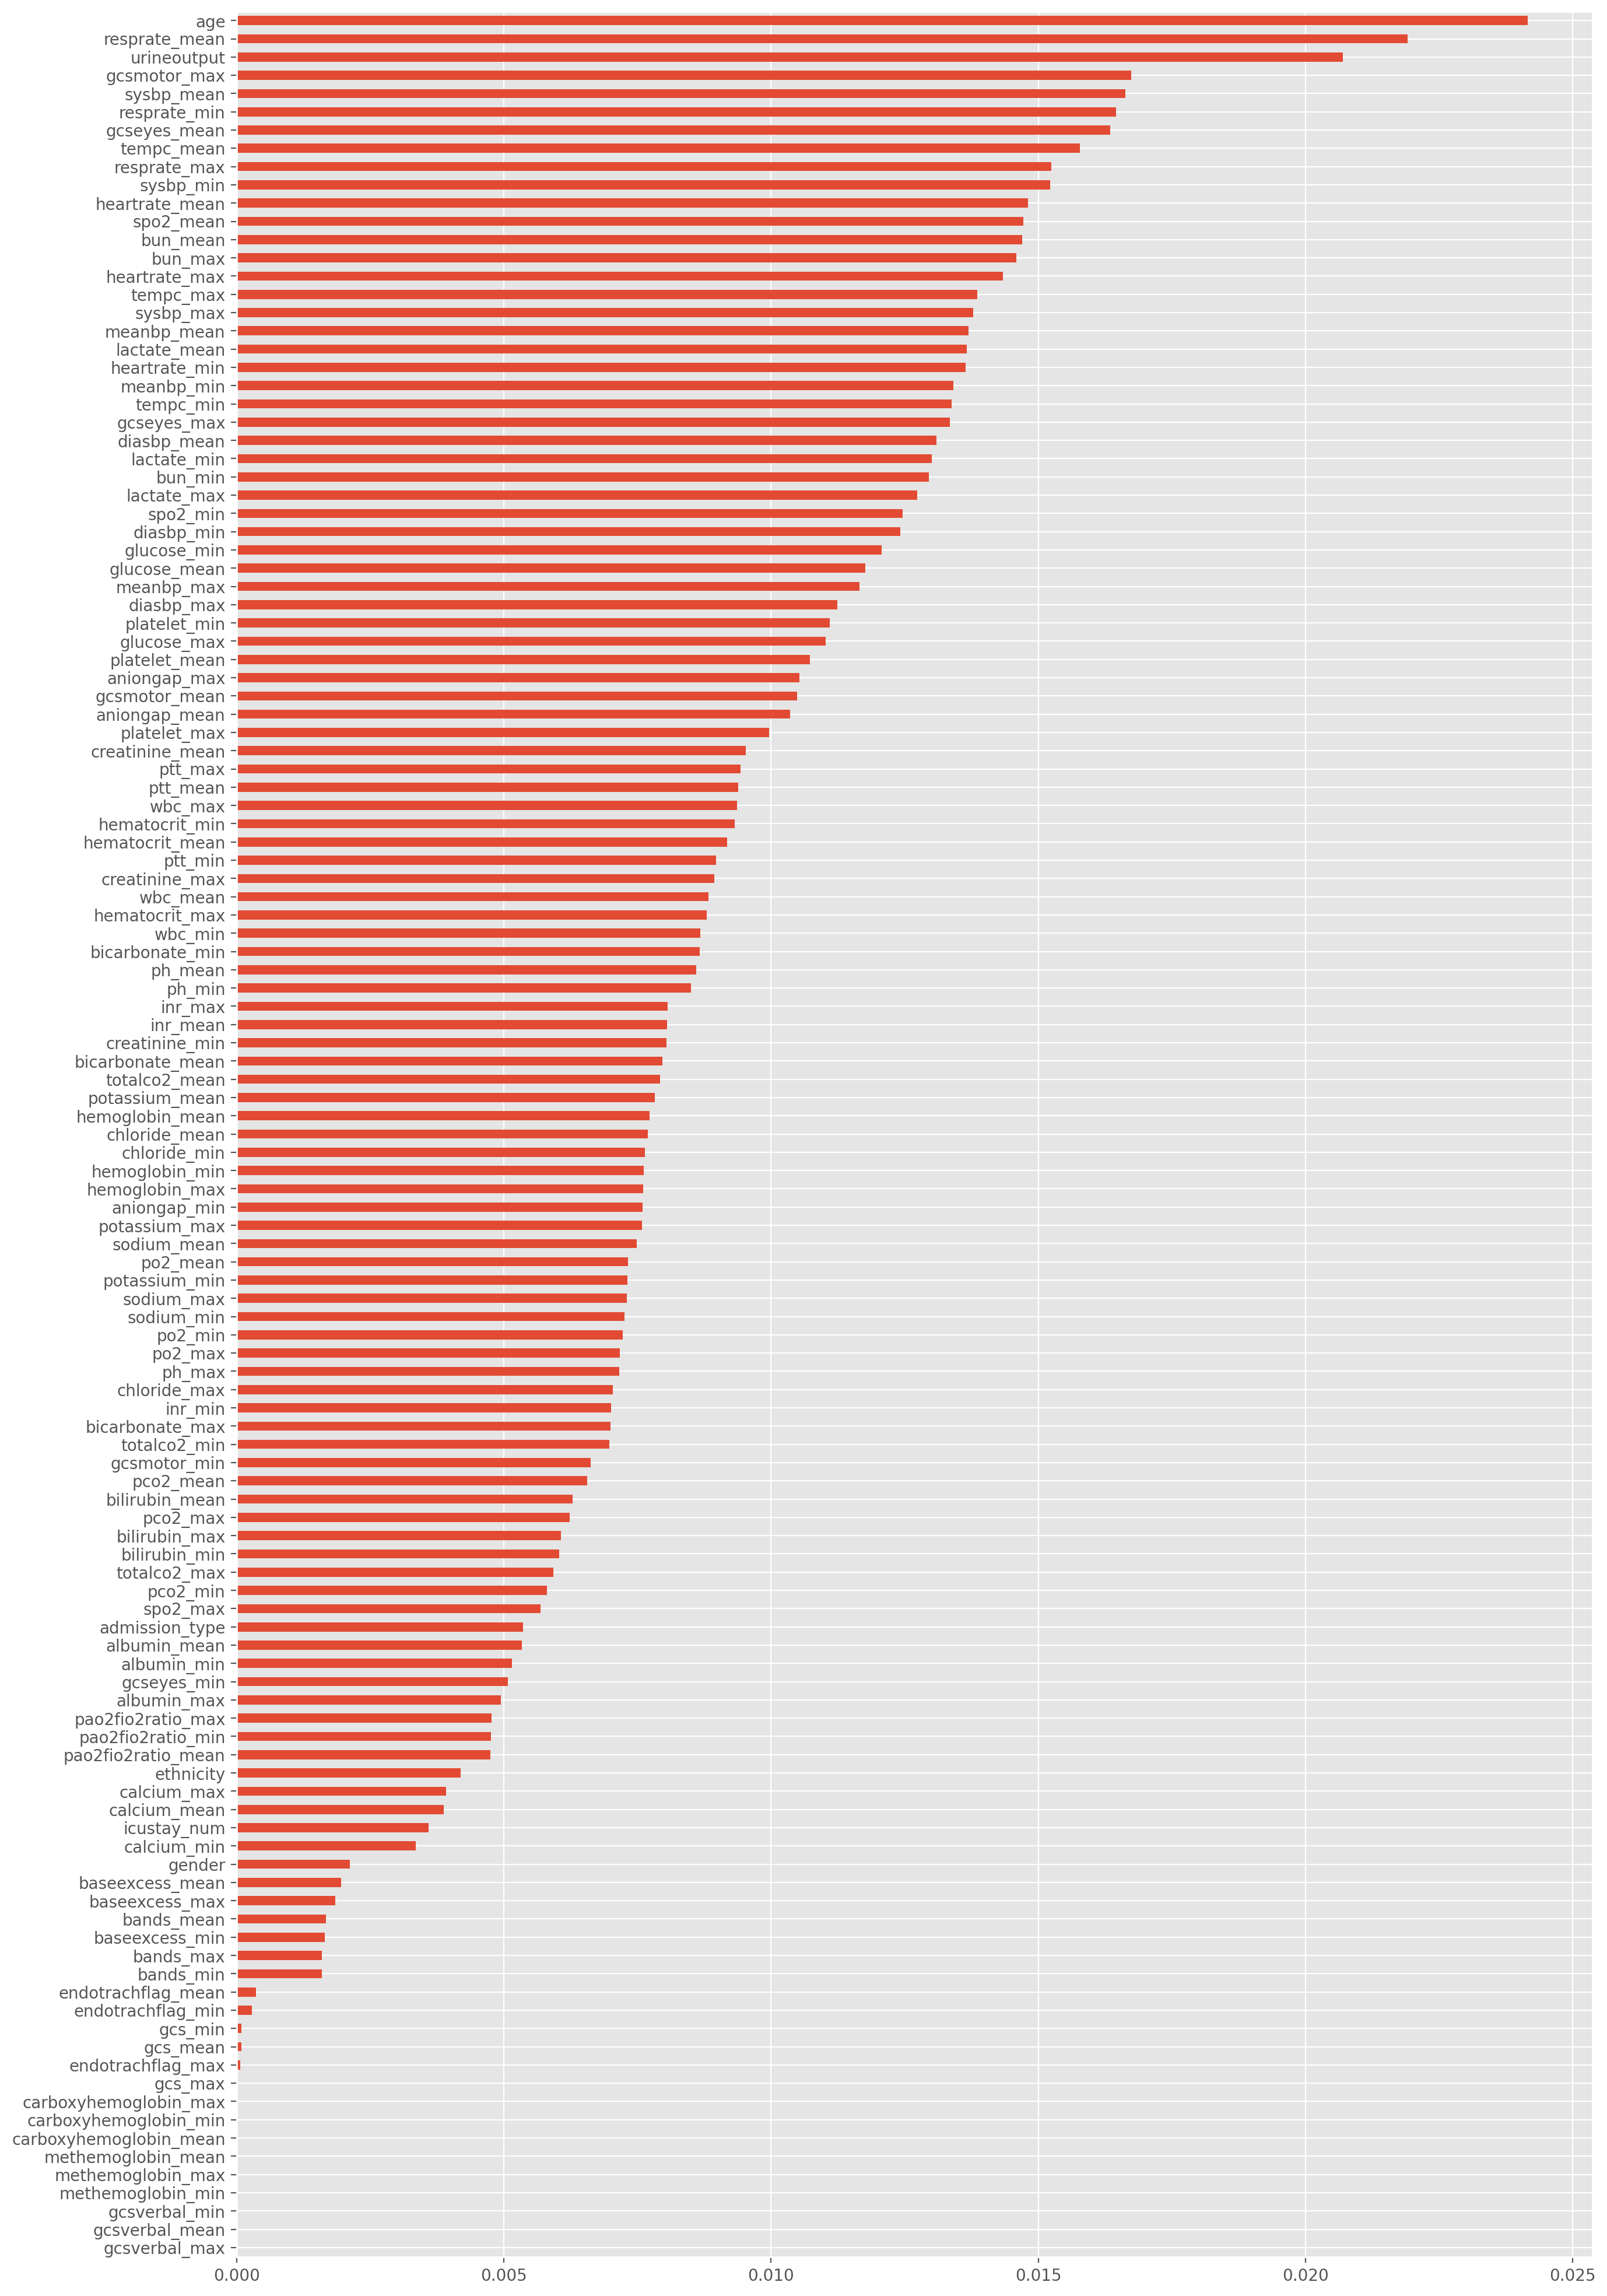

In [ ]:
# plot feature importance
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(15,25)
    
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
print("Top 10 features")
print(feat_importances.nlargest(10))

feat_importances.nsmallest(123).plot(kind='barh')

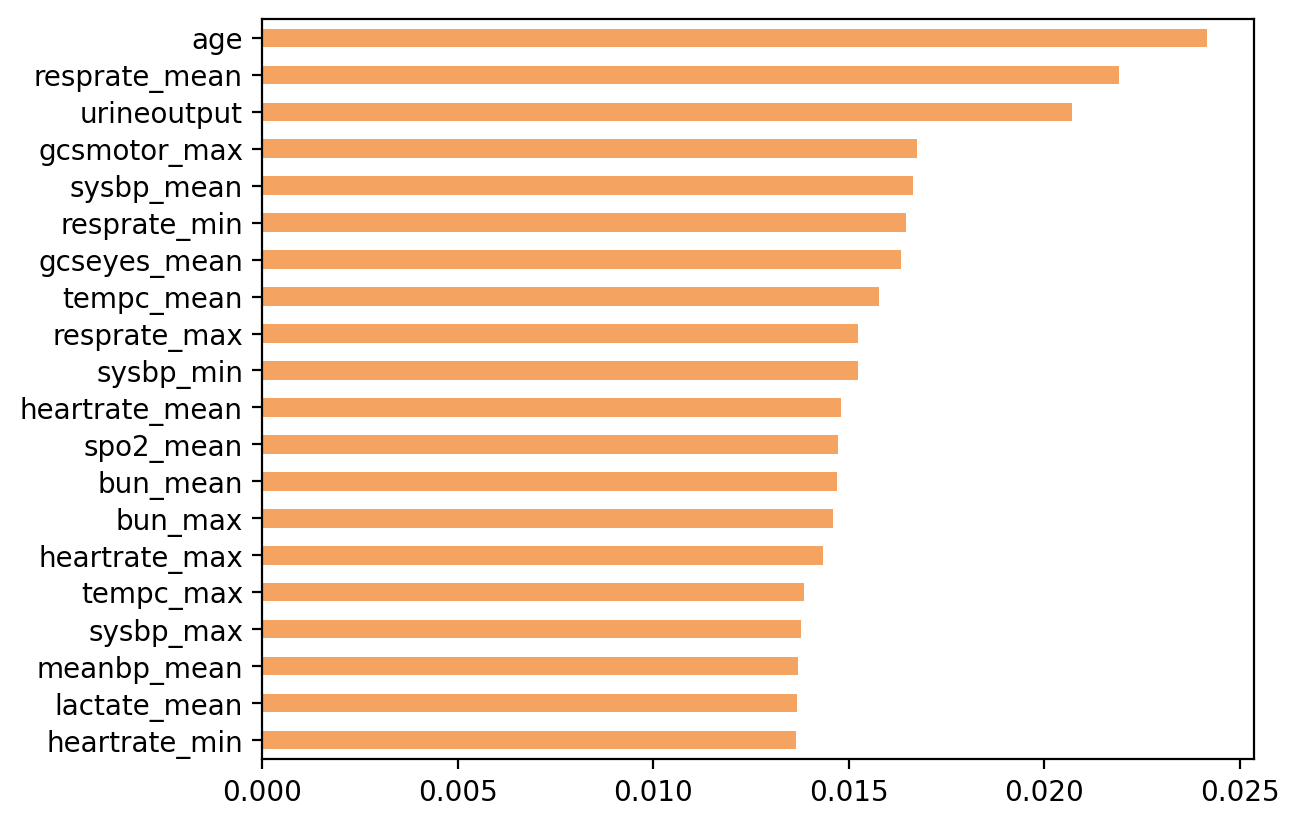

In [ ]:
# plot top 20 feature importance
plt.style.use('default')
fig.set_size_inches(15,10)
fig = plt.figure()
feat_importances.nlargest(20).sort_values(ascending=True).plot(kind='barh', color='sandybrown')
# Build the path to the Images folder
img_dir = current_directory / 'data' / 'Model' / 'Code' / 'Images'
img_dir.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist

# Save the figure
fig.savefig(img_dir / 'figure6.png', bbox_inches='tight', pad_inches=0.5)
#fig.savefig('../img/figure6.png', bbox_inches='tight', pad_inches=0.5)
plt.show()